# MapReduce using SPARK

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import string
import numpy as np
from itertools import chain

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Setting the font size 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Table of Contents

* [SPARK](#SPARK)
    * Installing Spark locally
* [Spark Context](#Spark-Context)
    * [Create A RDD](#Create-A-RDD)
    * [Call `collect` on an RDD: Lazy Spark](#Call-collect-on-an-RDD:-Lazy-Spark)
    * [Operations on RDDs](#Operations-on-RDDs)
    * [Word Examples](#Word-Examples)
    * [Key Value Pairs](#Key-Value-Pairs)
    * [word count 1](#word-count-1)
    * [word count 2:  `reduceByKey()`](#word-count-2:--reduceByKey%28%29)
    * [Nested Syntax](#Nested-Syntax)
    * [Using Cache](#Using-Cache)
    * [Fun with words](#Fun-with-words)
    * [DataFrames](#DataFrames)
    * [Machine Learning](#Machine-Learning)


With shameless stealing of some code and text from:

- https://github.com/tdhopper/rta-pyspark-presentation/blob/master/slides.ipynb
- Databricks and Berkeley Spark MOOC: https://www.edx.org/course/introduction-big-data-apache-spark-uc-berkeleyx-cs100-1x

which you should go check out.

## Installing Spark locally

**Python 3**    
with anaconda, run the following command in the terminal
```
conda install -c conda-forge pyspark 
```

**python 2**


**Step 1: Install Apache Spark**

For example, for Mac users using Homebrew:

```
$ brew install apache-spark
```

**Step 2: Install the Java SDK version 1.8 or above for your platform (not just the JRE runtime)**

Make sure you can access commands such as `java` on your command line.

**Step 3: Install the latest findspark package using pip**

```
➜  ~  pip install findspark
Collecting findspark
  Downloading findspark-0.0.5-py2.py3-none-any.whl
Installing collected packages: findspark
Successfully installed findspark-0.0.5
```

# Spark Context

You can also use it directly from the notebook interface on the mac if you installed `apache-spark` using `brew` and also installed `findspark` above.

In [3]:
import pyspark
sc = pyspark.SparkContext()

It also output's a bunch of stuff on my terminal. This is because the entire java context is started up.

```Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
15/10/21 14:46:15 INFO SparkContext: Running Spark version 1.4.0
2015-10-21 14:46:15.774 java[30685:c003] Unable to load realm info from SCDynamicStore
15/10/21 14:46:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/10/21 14:46:15 INFO SecurityManager: Changing view acls to: rahul
15/10/21 14:46:15 INFO SecurityManager: Changing modify acls to: rahul
15/10/21 14:46:15 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: Set(rahul); users with modify permissions: Set(rahul)
15/10/21 14:46:16 INFO Slf4jLogger: Slf4jLogger started
15/10/21 14:46:16 INFO Remoting: Starting remoting
15/10/21 14:46:16 INFO Remoting: Remoting started; listening on addresses :[akka.tcp://sparkDriver@10.251.101.163:64359]
15/10/21 14:46:16 INFO Utils: Successfully started service 'sparkDriver' on port 64359.
15/10/21 14:46:16 INFO SparkEnv: Registering MapOutputTracker
15/10/21 14:46:16 INFO SparkEnv: Registering BlockManagerMaster
15/10/21 14:46:16 INFO DiskBlockManager: Created local directory at /private/var/folders/_f/y76rs29s3c57ykwyz9c8z12c0000gn/T/spark-00a4e09e-e5db-485f-81dc-2e5016e9a27e/blockmgr-8966e07c-223b-4c38-9273-11543aa9d3c1
15/10/21 14:46:16 INFO MemoryStore: MemoryStore started with capacity 273.0 MB
15/10/21 14:46:16 INFO HttpFileServer: HTTP File server directory is /private/var/folders/_f/y76rs29s3c57ykwyz9c8z12c0000gn/T/spark-00a4e09e-e5db-485f-81dc-2e5016e9a27e/httpd-6af0a9e0-1cfe-42c4-a1bd-e01715b98436
15/10/21 14:46:16 INFO HttpServer: Starting HTTP Server
15/10/21 14:46:17 INFO Utils: Successfully started service 'HTTP file server' on port 64360.
15/10/21 14:46:17 INFO SparkEnv: Registering OutputCommitCoordinator
15/10/21 14:46:18 INFO Utils: Successfully started service 'SparkUI' on port 4040.
15/10/21 14:46:18 INFO SparkUI: Started SparkUI at http://10.251.101.163:4040
15/10/21 14:46:18 INFO Executor: Starting executor ID driver on host localhost
15/10/21 14:46:18 INFO Utils: Successfully started service 'org.apache.spark.network.netty.NettyBlockTransferService' on port 64361.
15/10/21 14:46:18 INFO NettyBlockTransferService: Server created on 64361
15/10/21 14:46:18 INFO BlockManagerMaster: Trying to register BlockManager
15/10/21 14:46:18 INFO BlockManagerMasterEndpoint: Registering block manager localhost:64361 with 273.0 MB RAM, BlockManagerId(driver, localhost, 64361)
15/10/21 14:46:18 INFO BlockManagerMaster: Registered BlockManager
```

In [4]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

### Let's see the difference in time between operation running on pyspark and python

In [5]:
## Python numpy

import numpy
% time np.sum(list(map(lambda x: x**2, range(1000000))))

CPU times: user 606 ms, sys: 37.3 ms, total: 643 ms
Wall time: 644 ms


333332833333500000

In [6]:
# Using pyspark
%time sc.parallelize(range(1000000)).map(lambda x: x**2).sum()

CPU times: user 15.8 ms, sys: 6.05 ms, total: 21.8 ms
Wall time: 1.99 s


333332833333500000

### Create A Resilient Distributed Dataset (RDD)


### Quick note:
#### Transformations Vs actions

RDD methods of two kinds:
1. Transformations: Return another RDD. Are not performed until an action is called (lazy)
2. Actions: Return a value other than an RDD. Performed immediately

In [7]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print(type(wordsRDD))

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

Spark is lazy. Until you `collect`, nothing is actually run.

>Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program.

In [8]:
wordsRDD.collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

### Operations on RDDs

From the Spark Programming Guide:

>RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

### Word Examples

In [9]:
def makePlural(word):
    return word + 's'

print(makePlural('cat'))

cats


Transform one RDD into another.

In [10]:
pluralRDD = wordsRDD.map(makePlural)
print(pluralRDD.first())
print(pluralRDD.take(2))


cats
['cats', 'elephants']


In [11]:
pluralRDD.take(1)

['cats']

In [12]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

### Key Value Pairs

In [13]:
wordPairs = wordsRDD.map(lambda w: (w, 1))
print(wordPairs.collect())

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


### WORD COUNT!

This little exercise shows how to use mapreduce to calculate the counts of individual words in a list.

In [14]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print(wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


### Getting RDD Lineage Graph — toDebugString Method

![Tons of shuffling](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/images/reduce_by.png)

In [15]:
print((wordsRDD
       .map(lambda w: (w, 1))
       .reduceByKey(lambda x,y: x+y)).toDebugString())

b'(4) PythonRDD[19] at RDD at PythonRDD.scala:48 []\n |  MapPartitionsRDD[18] at mapPartitions at PythonRDD.scala:436 []\n |  ShuffledRDD[17] at partitionBy at NativeMethodAccessorImpl.java:0 []\n +-(4) PairwiseRDD[16] at reduceByKey at <ipython-input-15-83f280bff28c>:3 []\n    |  PythonRDD[15] at reduceByKey at <ipython-input-15-83f280bff28c>:3 []\n    |  ParallelCollectionRDD[9] at parallelize at PythonRDD.scala:489 []'


### Using Cache

>Caching or persistence are optimization techniques for (iterative and interactive) Spark computations. They help saving interim partial results so they can be reused in subsequent stages. These interim results as RDDs are thus kept in memory (default) or more solid storage like disk and/or replicated. RDDs can be cached using cache operation. They can also be persisted using persist operation.

### *Warning*  -Cache judiciously... see ((Why) do we need to call cache or persist on a RDD)
Just because you can cache a RDD in memory doesn’t mean you should blindly do so. Depending on how many times the dataset is accessed and the amount of work involved in doing so, recomputation can be faster than the price paid by the increased memory pressure.

It should go without saying that if you only read a dataset once there is no point in caching it, it will actually make your job slower. The size of cached datasets can be seen from the Spark Shell..

source: https://stackoverflow.com/questions/26870537/what-is-the-difference-between-cache-and-persist

In [16]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
print(wordsRDD)
wordsRDD.count()

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:489


5

Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.

In [17]:
#this is rerun from the start
wordsRDD.count()

5

In [18]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:489

In [19]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [20]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So `cache` or `persist` serves as a checkpoint, breaking the RDD chain or the *lineage*.

In [21]:
birdsList=['heron','owl']
animList=wordsList+birdsList
animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birdsList:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [22]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()

#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()

#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print("mammal count {} and bird count {}".format(mammalcount, birdcount))

mammal count 5 and bird count 2


### Exercises: Fun with MapReduce

Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file `./sparklect/english.stop.txt` contains a list of English stopwords, while the file `./sparklect/shakes/juliuscaesar.txt` contains the entire text of Shakespeare's 'Julius Caesar'.

* Load all of the stopwords into a Python list
* Load the text of Julius Caesar into an RDD using the `sparkcontext.textfile()` method. Call it `juliusrdd`.

In [23]:
# Loading stopwords
stopwords = open('./sparklect/english.stop.txt', 'r').read().split('\n')   
len(np.unique(stopwords))

571

In [24]:
stopwords[1:10]

["a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after']

In [25]:
## Loading Julius Caesar text
juliusrdd = sc.textFile("sparklect/shakes/juliuscaesar.txt")

#### How many words does Julius Caesar have? 

We will start with remove punctuations and convert the text to lower letters in the data

In [26]:
remove_punc = str.maketrans('', '', string.punctuation)
juliusrdd = juliusrdd.map(lambda x: x.lower().translate(remove_punc).split())

In [27]:
count_wordsrdd = juliusrdd.flatMap(chain)
print("Number of words in the document Julius Caesar is {}".format(count_wordsrdd.count()))

Number of words in the document Julius Caesar is 21201



#### Remove stop words and  print the first 20 words of Julius Caesar as a Python list.

In [28]:
count_wordsrdd = count_wordsrdd.filter(lambda x: x not in stopwords)
count_wordsrdd.take(20)

['1599',
 'tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'general',
 'octavius',
 'triumvir',
 'caesars',
 'death',
 'augustus',
 'caesar',
 'emperor']

#### Top 20 words

In [29]:
top20_words = count_wordsrdd.map(lambda t: (t, 1)).reduceByKey(lambda x,y: x+y).takeOrdered(20, key=lambda x: -x[1])
top20_words

[('brutus', 366),
 ('caesar', 237),
 ('cassius', 227),
 ('antony', 128),
 ('thou', 116),
 ('casca', 72),
 ('good', 71),
 ('citizen', 69),
 ('men', 64),
 ('lucius', 59),
 ('man', 56),
 ('thy', 54),
 ('thee', 54),
 ('messala', 47),
 ('lord', 44),
 ('enter', 43),
 ('octavius', 43),
 ('rome', 43),
 ('caesars', 42),
 ('cinna', 40)]


#### Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

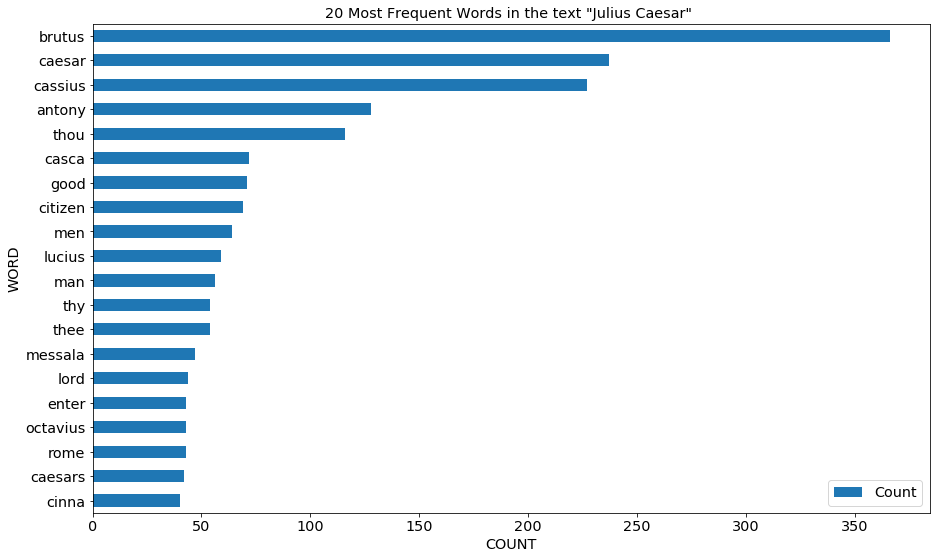

In [30]:
pd.DataFrame(top20_words, columns=['Word', 'Count'])\
.sort_values('Count')\
.plot(x='Word', y='Count', kind='barh', figsize=(15,9))
plt.xlabel('COUNT')
plt.ylabel('WORD')
plt.title('20 Most Frequent Words in the text "Julius Caesar" ')
plt.show()


### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

>You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

>For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [31]:
shakesrdd=sc.textFile("./sparklect/shakes/*.txt", minPartitions=4)

In [32]:
shakesrdd.take(10)

['1601',
 'AS YOU LIKE IT',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'DRAMATIS PERSONAE.',
 '',
 '']

In [33]:
translator = str.maketrans('', '', string.punctuation)
shakesrdd = shakesrdd.map(lambda x: x.lower().translate(translator).split())

In [34]:
word_counts = shakesrdd.flatMap(chain).map(lambda t: (t, 1)).reduceByKey(lambda x,y: x+y)
word_counts.filter(lambda x: x[0] not in stopwords).takeOrdered(20, key=lambda x: -x[1])

[('thou', 2129),
 ('thy', 1548),
 ('sir', 1320),
 ('thee', 1257),
 ('good', 1200),
 ('lord', 1116),
 ('love', 939),
 ('enter', 892),
 ('hath', 793),
 ('man', 783),
 ('ill', 768),
 ('make', 654),
 ('tis', 613),
 ('king', 596),
 ('give', 574),
 ('duke', 568),
 ('speak', 528),
 ('brutus', 478),
 ('time', 471),
 ('exit', 443)]

## Optional topic 1: DataFrames

Pandas and Spark dataframes can be easily converted to each other, making it easier to work with different data formats. This section shows some examples of each.

Convert Spark DataFrame to Pandas

`pandas_df = spark_df.toPandas()`

Create a Spark DataFrame from Pandas

`spark_df = context.createDataFrame(pandas_df)`

Must fit in memory.

![](https://ogirardot.files.wordpress.com/2015/05/rdd-vs-dataframe.png?w=640&h=360)

VERY IMPORTANT: DataFrames in Spark are like RDD in the sense that they’re an immutable data structure.

In [35]:
df=pd.read_csv("sparklect/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Convert this pandas dataframe to a Spark dataframe

In [36]:
from pyspark.sql import SQLContext
print(sc)
sqlsc=SQLContext(sc)
sparkdf = sqlsc.createDataFrame(df)
sparkdf

<SparkContext master=local[*] appName=pyspark-shell>


DataFrame[Gender: string, Height: double, Weight: double]

In [37]:
sparkdf.show(5)

+------+-----------------+----------------+
|Gender|           Height|          Weight|
+------+-----------------+----------------+
|  Male|  73.847017017515|241.893563180437|
|  Male|68.78190404589029|  162.3104725213|
|  Male|74.11010539178491|  212.7408555565|
|  Male| 71.7309784033377|220.042470303077|
|  Male| 69.8817958611153|206.349800623871|
+------+-----------------+----------------+
only showing top 5 rows



In [38]:
type(sparkdf.Gender)

pyspark.sql.column.Column

In [39]:
temp = sparkdf.rdd.map(lambda r: r.Gender)
print(type(temp))
temp.take(10)

<class 'pyspark.rdd.PipelinedRDD'>


['Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male']

## Optional topic 2: Machine Learning using Spark

While we don't go in-depth into machine learning using spark here, this sample code will help you get started.

In [40]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

Now create a data set from the Spark dataframe

In [41]:
data=sparkdf.rdd.map(lambda row: LabeledPoint(row.Gender=='Male',[row.Height, row.Weight]))
data.take(5)

[LabeledPoint(1.0, [73.8470170175,241.89356318]),
 LabeledPoint(1.0, [68.7819040459,162.310472521]),
 LabeledPoint(1.0, [74.1101053918,212.740855557]),
 LabeledPoint(1.0, [71.7309784033,220.042470303]),
 LabeledPoint(1.0, [69.8817958611,206.349800624])]

In [42]:
data2=sparkdf.rdd.map(lambda row: LabeledPoint(row[0]=='Male',row[1:]))
data2.take(1)[0].label, data2.take(1)[0].features

(1.0, DenseVector([73.847, 241.8936]))

Split the data set into training and test sets

In [43]:
train, test = data.randomSplit([0.7,0.3])
train.cache()
test.cache()

PythonRDD[60] at RDD at PythonRDD.scala:48

In [44]:
type(train)

pyspark.rdd.PipelinedRDD

Train the logistic regression model using MLIB

In [45]:
model = LogisticRegressionWithLBFGS.train(train)

In [46]:
model.weights

DenseVector([-0.4754, 0.1955])

Run it on the test data

In [47]:
results = test.map(lambda lp: (lp.label, float(model.predict(lp.features))))
print(results.take(10))
type(results)                       

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 0.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]


pyspark.rdd.PipelinedRDD

Measure accuracy and other metrics

In [48]:
test_accuracy=results.filter(lambda x: x[0]==x[1]).count()/float(results.count())
test_accuracy

0.9250911501491548

In [49]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(results)

In [50]:
print(type(metrics))
metrics.areaUnderROC

<class 'pyspark.mllib.evaluation.BinaryClassificationMetrics'>


0.9251272774282968

In [51]:
type(model)

pyspark.mllib.classification.LogisticRegressionModel

In [52]:
!rm -rf mylogistic.model

In [53]:
model.save(sc, "mylogistic.model")

The pipeline API automates a lot of this stuff, allowing us to work directly on dataframes. It is not all supported in Python, as yet. 

Also see:

- http://jordicasanellas.weebly.com/data-science-blog/machine-learning-with-spark
- http://spark.apache.org/docs/latest/mllib-guide.html
- http://www.techpoweredmath.com/spark-dataframes-mllib-tutorial/
- http://spark.apache.org/docs/latest/api/python/
- http://spark.apache.org/docs/latest/programming-guide.html

`rdd.saveAsTextFile()` saves an RDD as a string.

In [54]:
sc.stop()